# Wind turbines

In [2]:
# setup site used in this tutorial
import matplotlib.pyplot as plt
import numpy as np
from dynamiks.utils import doc_utils # use cached animations in sphinx documentation
from dynamiks.sites.turbulence_fields import MannTurbulenceField
from dynamiks.utils.test_utils import tfp, DemoSite
from dynamiks.sites._site import TurbulenceFieldSite
from py_wake.utils.plotting import setup_plot

ws = 10
ti = 0.06
site = DemoSite(ws,ti)

## Actuator disk wind turbines

Simple actuator disk wind turbines are defined in terms of 

- Position
- Name
- Diameter
- Hubheight
- Power curve
- Ct curve

This turbine type is really fast but does not model the blades or structural loads

Actuator disk wind turbines can e.g. be generated from PyWake wind turbines (predefined, generic or custom) 

In [3]:
# instantiate a V80 and a generic 3.4MW PyWake wind turbines
from py_wake.wind_turbines import WindTurbines
from py_wake.examples.data.hornsrev1 import V80
from py_wake.wind_turbines.generic_wind_turbines import GenericWindTurbine
v80 = V80()
generic = GenericWindTurbine("Generic 3.4MW", diameter=130, hub_height=110, power_norm=3400, turbulence_intensity=.1)

# collect the two turbines in one WindTurbines object
pywake_windTurbines = WindTurbines.from_WindTurbine_lst([v80,generic])

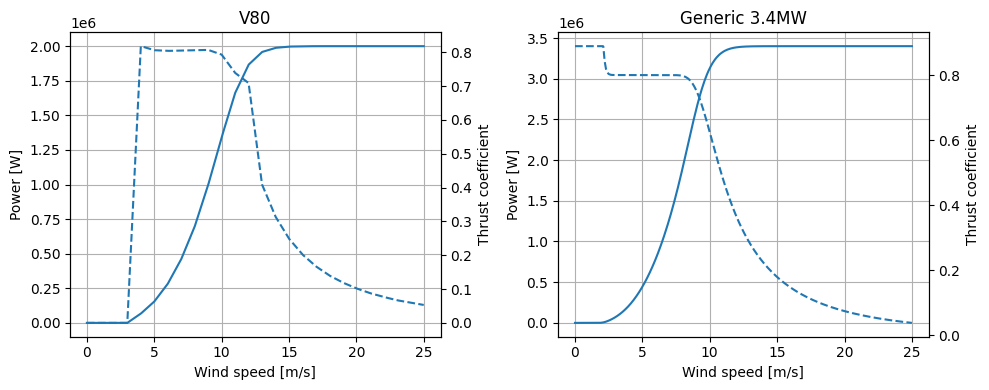

In [4]:
# plot power and ct curves
axes = plt.subplots(1,2, figsize=(10,4))[1]
for t, ax in zip(pywake_windTurbines.types(), axes):
    plt.sca(ax)
    pywake_windTurbines.plot_power_ct(type=t)
    plt.tight_layout()

In [5]:
# instantiate a dynamiks WindTurbines object
from dynamiks.wind_turbines import PyWakeWindTurbines

wts = PyWakeWindTurbines(x=[0,500,1000], y=[0,0,0],   # x and y position of two wind turbines
                         windTurbine=pywake_windTurbines,
                         types=[0,1,0])

# print diameter and hub height
for i,(xyz) in enumerate(wts.positions_east_north.T):
    print(f'WT{i}, diameter: {wts[i].diameter()}, hub height: {wts[i].hub_height()}, position: {tuple(xyz)}')

WT0, diameter: [80.], hub height: [70.], position: (0.0, 0.0, 0.0)
WT1, diameter: [130.], hub height: [110.], position: (500.0, 0.0, 0.0)
WT2, diameter: [80.], hub height: [70.], position: (1000.0, 0.0, 0.0)


In [6]:
from dynamiks.dwm.dwm_flow_simulation import DWMFlowSimulation
from dynamiks.dwm.particle_deficit_profiles.ainslie import jDWMAinslieGenerator
from dynamiks.views import XYView

fs = DWMFlowSimulation(site=site, windTurbines=wts, particleDeficitGenerator=jDWMAinslieGenerator(), dt=1)
fs.run(10)

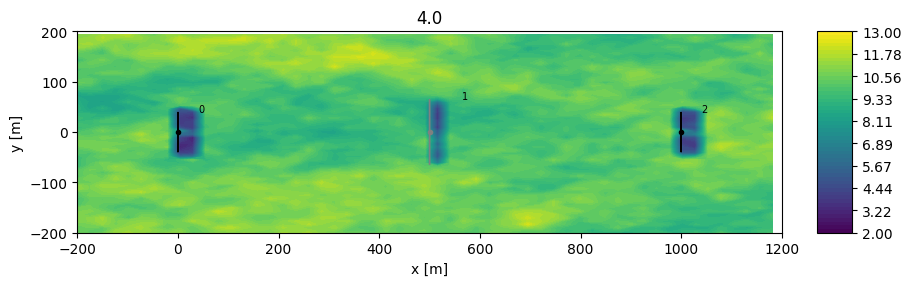

In [7]:
ax = plt.figure(figsize=(10,4)).gca()
view = XYView(z=70, x=np.linspace(-200,1200), y=np.linspace(-200,200), ax=ax)
fs.visualize(fs.time+100, view=view, id='WindTurbines_AD')

### Output from wind turbines
Wind turbines has a `sensor` object with a set of predefined sensors.
Additional sensors can be added by the method `windTurbines.add_sensor`

In [8]:
help(wts.add_sensor)

Help on method add_sensor in module dynamiks.wind_turbines._windTurbines:

add_sensor(name, getter=None, setter=None, expose=False, ext_lst=None) method of dynamiks.wind_turbines.pywake_windturbines.PyWakeWindTurbines instance
    add a wind turbine sensor
    
    Sensor values available using: windTurbines.sensors.<name>
    
    Parameters
    ----------
    name : str
        Name of sensor. Cannot contain spaces
    getter : function
        function, f(wt) -> sensor_value
    setter : function, optional
        function, f(wt, value) -> None,
    expose : boolean, optional
        if True, the getter/setter is exposed to the wind turbine enabling e.g. wt.yaw as a shorthand for wt.sensors.yaw
    Examples
    --------
    windTurbines.add_sensor('power', lambda wt: wt.power())



An xarray data array with all sensor data can be obtained as follows

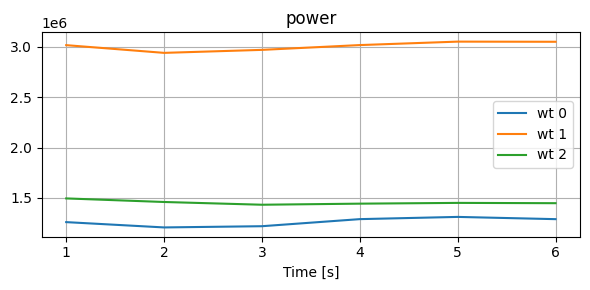

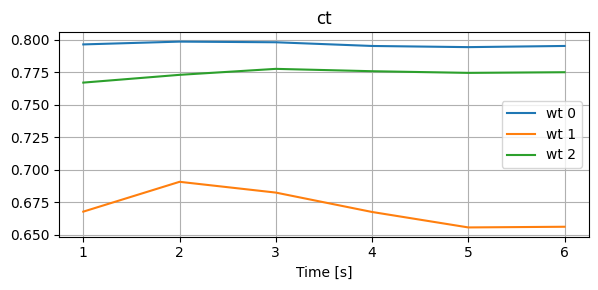

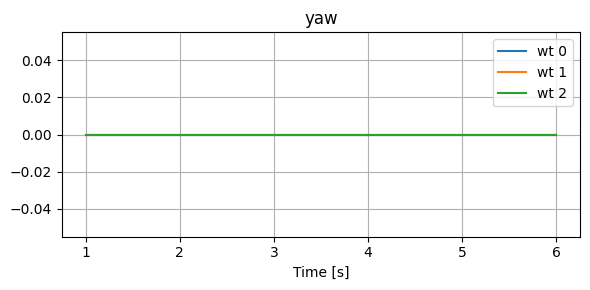

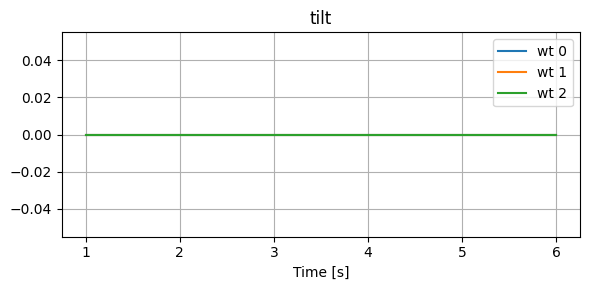

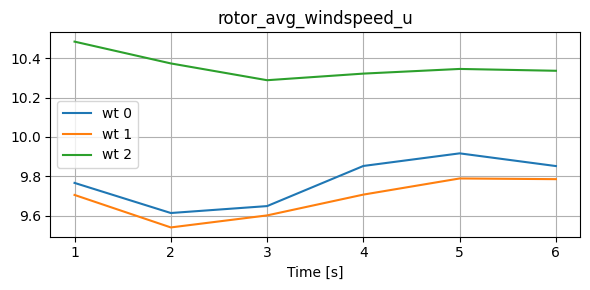

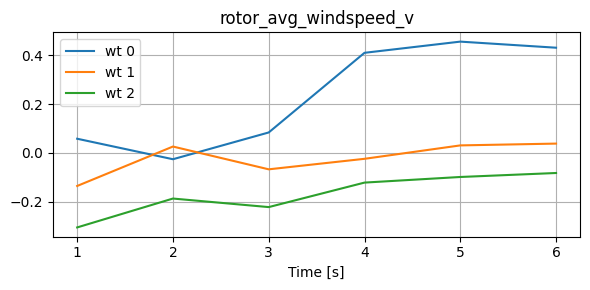

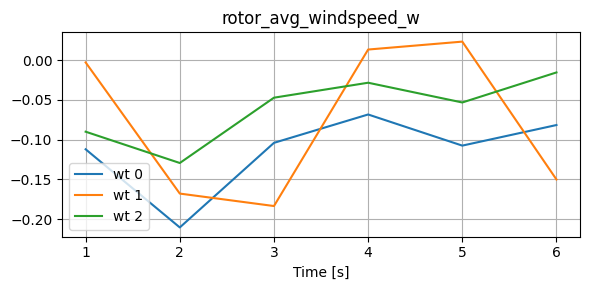

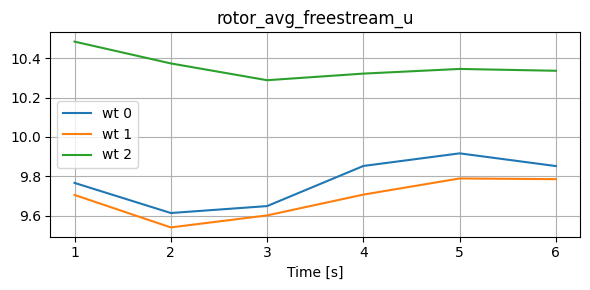

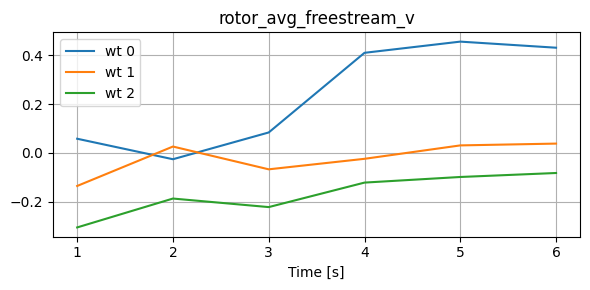

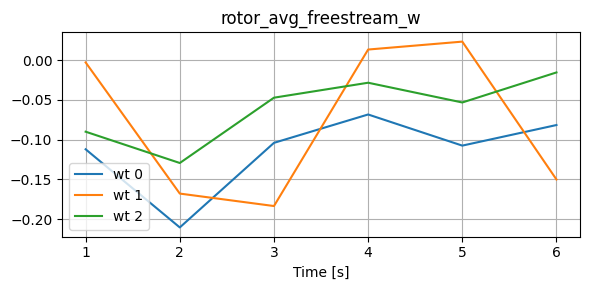

In [9]:
fs.run(200)
da = wts.sensors.to_xarray()
for sensor in da.sensor:
    plt.figure(figsize=(6,3))
    for wt in da.wt:
        da.sel(sensor=sensor, wt=wt).plot(label=f'wt {wt.item()}')
    setup_plot(title=sensor.item(), xlabel='Time [s]')

## HAWC2 wind turbine

The HAWC2 wind turbine provides a higher fidelity model that combines a multibody structural formulation with aerodynamic forces acting on the rotating blades. This model captures structural loads and handles wind speed variations over the rotor, but the computational costs are higher than the actuator disk models.

To use the HAWC2 wind turbines you need:

- `h2lib`: A [library version](https://hawc2.pages.windenergy.dtu.dk/HAWC2Lib/) of HAWC2. It can be installed by `pip install dynamiks[hawc2]`, see [installation](../installation).
- A valid license
- HAWC2 models of the wind turbines

### HAWC2-DWM (HAWC2Farm)
HAWC2 is capable of simulating one wind turbine and therefore multiple HAWC2 instances are needed to simulate a wind farm in Dynamiks.

When coupling HAWC2 with the DWM wind farm flow model, the wind speed module of HAWC2 is bypassed. Instead the turbulent wind speeds including mean wind, shear, gusts, wakes etc. are calculated by Dynamiks on a 3D grid covering an aera around each wind turbine and passed to the corresponding HAWC2 instance.

Each HAWC2 instance will use the provided wind speeds to calculate the aerodynamic forces on the blades, the induction and the structural response.

Finally Dynamiks receives the induction and structural states which is used by the DWM model to calculate the wakes.

![HAWC2-DWM_coupling](HAWC2-DWM_coupling.svg)

In [10]:
from dynamiks.wind_turbines.hawc2_windturbine import HAWC2WindTurbines
from h2lib_tests.test_files import tfp as h2lib_tfp
htc_filename_lst = [h2lib_tfp + "DTU_10_MW/htc/DTU_10MW_RWT.htc",
                    h2lib_tfp + "IEA-15-240-RWT-Onshore/htc/IEA_15MW_RWT_Onshore_simple.htc"]
wts = HAWC2WindTurbines(x=[0,500,1000], y=[0,0,0], 
                        htc_filename_lst=htc_filename_lst, 
                        types=[0, 1, 0], 
                        case_name='MyTestCase', # subfolder name in the htc, res and log folders
                        suppress_output=False # don't show hawc2 output in console
                       )

In [11]:
from dynamiks.dwm.dwm_flow_simulation import DWMFlowSimulation
from dynamiks.dwm.particle_deficit_profiles.ainslie import jDWMAinslieGenerator
from dynamiks.views import XYView
fs = DWMFlowSimulation(site=site, windTurbines=wts, particleDeficitGenerator=jDWMAinslieGenerator(), dt=1)

In [12]:
# Add rotor speed and azimuth sensor
wts.add_sensor("rotor", "constraint bearing1 shaft_rot 2", ext_lst=['azi','speed']);

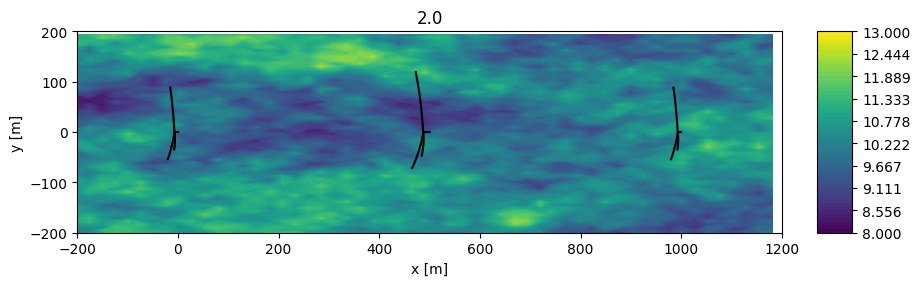

In [13]:
ax = plt.figure(figsize=(10,4)).gca()
view = XYView(z=70, x=np.linspace(-200,1200), y=np.linspace(-200,200), ax=ax)
fs.visualize(fs.time+100, id='WindTurbines_H2', view=view)

### Output from HAWC2

Output form the HAWC2 instances can be obtained during the simulation by Dynamiks (with the Dynamiks time resolution) or from the HAWC2 result file (with the HAWC2 time resolution).

**During simulation by Dynamiks**

Output from HAWC2 can be obtained during simulation by Dynamiks. To use this option, the needed sensors must be added in advance, see code cell above where a rotor speed and azimuth sensor are added.

The HAWC2WindTurbine extends the `add_sensor` method, such that 

- the `getter` argument can be a HAWC2 sensor string
- the `setter` argument can be a int, which is interpreted as the index of a `general variable` sensor to set. In this way, e.g. yaw or derating setpoints can be set

Note, that some sensors, e.g. `aero_power`, `aero_thrust` and rotor center wind speed are predefined.

In [14]:
help(wts.add_sensor)

Help on method add_sensor in module dynamiks.wind_turbines.hawc2_windturbine:

add_sensor(name, getter=None, setter=None, expose=False, ext_lst=None) method of dynamiks.wind_turbines.hawc2_windturbine.HAWC2WindTurbines instance
    add a wind turbine sensor
    
    Sensor values available using: windTurbines.sensors.<name>
    
    Parameters
    ----------
    name : str
        Name of sensor. Cannot contain spaces
    getter : str, function
        if str: HAWC2 sensor string, e.g. "constraint bearing1 shaft_rot 2"
        if function: f(wt) -> sensor_value
    setter : int, function or None, optional
        if int, index of the HAWC2 'general variable' sensor to set
        if function, f(wt, value) -> None,



In [15]:
from dynamiks.utils.data_dumper import DataDumper

fs.run(fs.time+20, verbose=1) # run another 20s

  0%|          | 0/2 [00:00<?, ?it/s]

An xarray dataarray with the sensor data can be obtained by:

In [16]:
da = wts.sensors.to_xarray()
da.head(time=1)

<xarray.DataArray (time: 1, wt: 3, sensor: 13)> Size: 312B
array([[[ 0.00000000e+00,  0.00000000e+00,  1.01961648e+01,
          3.37760348e-01, -1.19160775e-01,  1.03250596e+01,
          1.02839903e-01, -2.47561810e-01,  1.03250596e+01,
          1.02839903e-01, -2.47561810e-01,  1.14509792e+01,
          1.90896757e+00],
        [ 0.00000000e+00,  0.00000000e+00,  8.88295218e+00,
         -4.99334509e-01,  8.80648176e-02,  1.02902738e+01,
          6.63340054e-03, -1.19509040e-01,  1.02902738e+01,
          6.63340054e-03, -1.19509040e-01,  1.14391023e+01,
          1.90643692e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.01684484e+01,
         -8.80610846e-02, -2.42795789e-01,  1.01546112e+01,
          8.11121999e-03, -1.27453143e-01,  1.01546112e+01,
          8.11121999e-03, -1.27453143e-01,  1.14509792e+01,
          1.90896757e+00]]])
Coordinates:
  * time     (time) float64 8B 1.0
  * wt       (wt) int32 12B 0 1 2
  * sensor   (sensor) <U22 1kB 'aero_power' 'aero_thrust' ... 'rotor_speed'

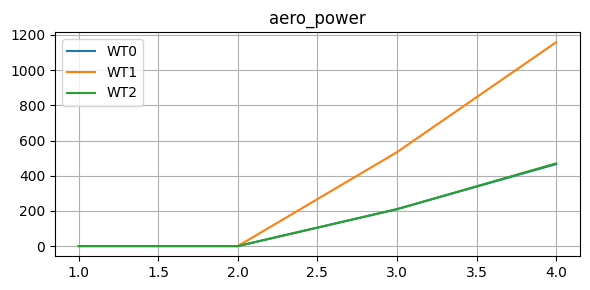

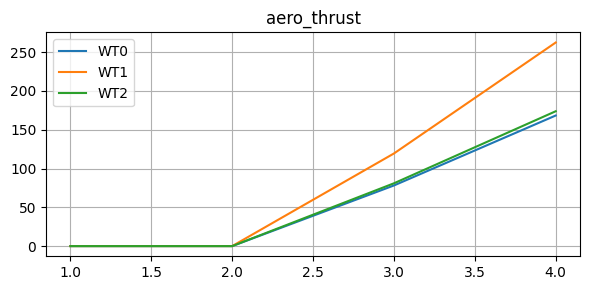

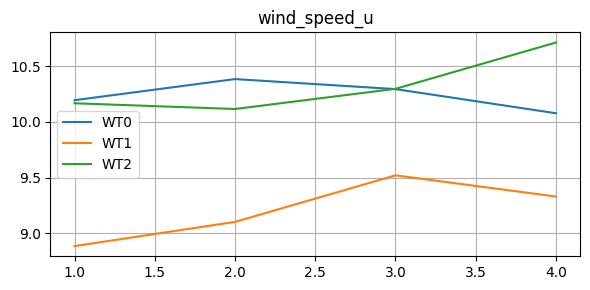

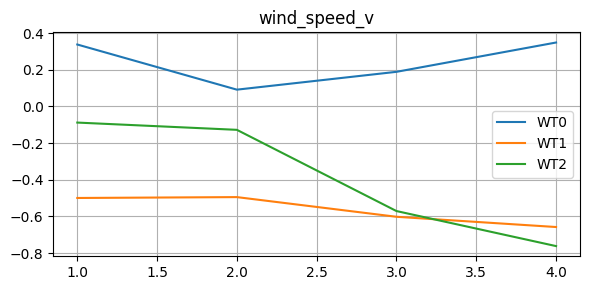

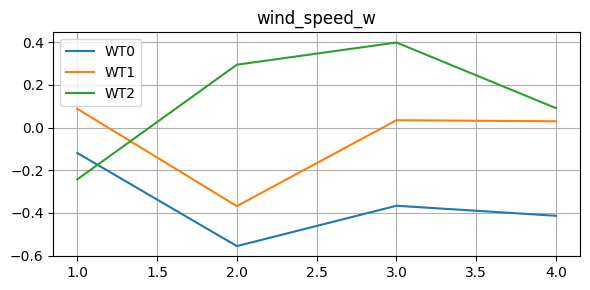

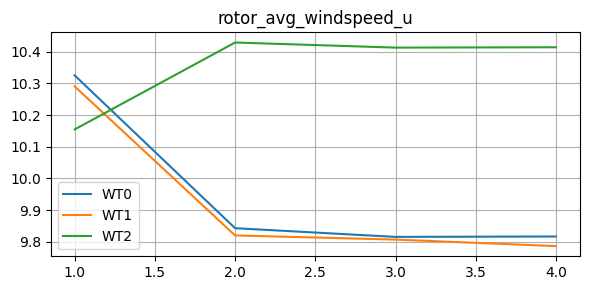

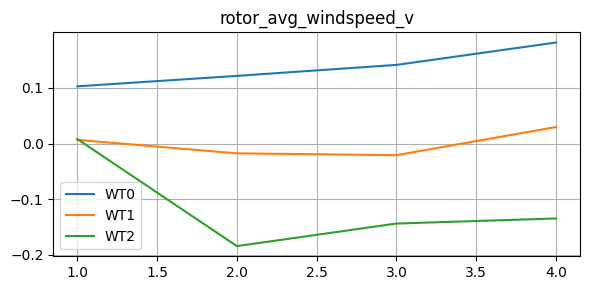

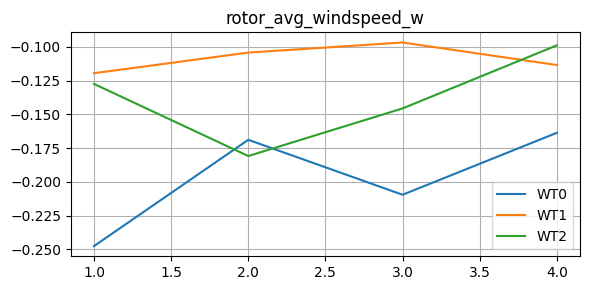

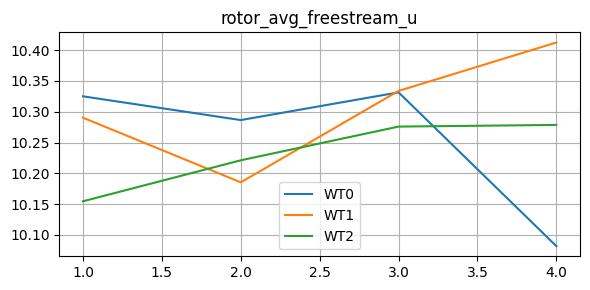

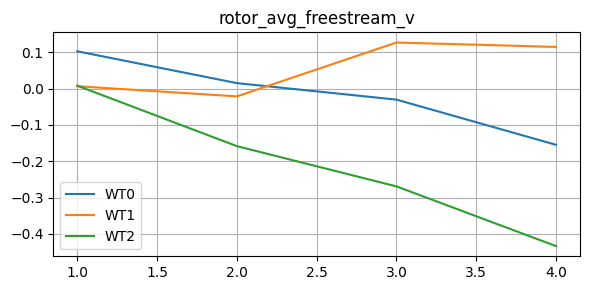

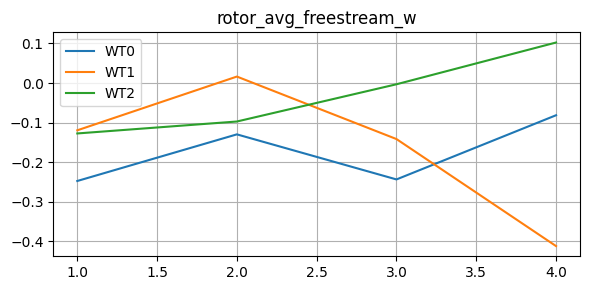

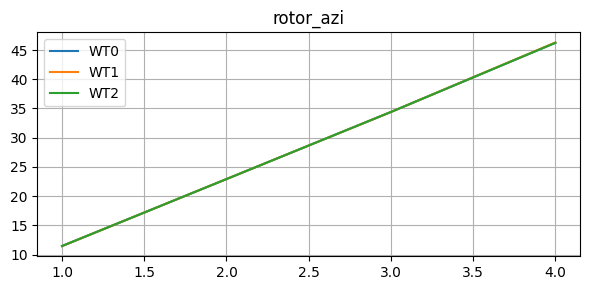

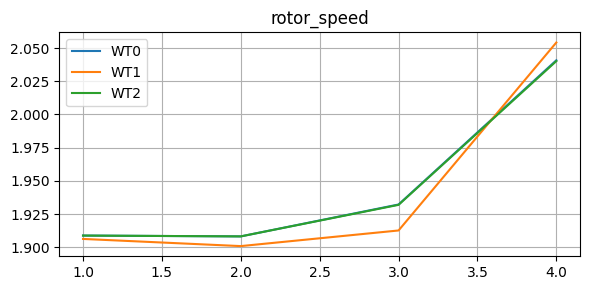

In [17]:
for sensor in da.sensor:
    plt.figure(figsize=(6,3))
    for wt in da.wt:
        da.sel(sensor=sensor, wt=wt).plot(label=f'WT{wt.item()}')
    setup_plot(title=sensor.item())

**HAWC2 result file**

Output from HAWC2 can be obtained from a HAWC2 result file, when that file is written. When the file is written depends on 

- htc.simulation.time_stop (result file output stops at time_stop, note, time_stop is overridden by htc.output.time)
- htc.output.data_format (`gtsdf`, `gtsdf64` and `hawc_ascii` are written during simulation while `hawc_binary` and `flex_int` are written at time stop)
- htc.output.buffer (`gtsdf`, `gtsdf64` and `hawc_ascii` every `buffer` time steps))
- htc.output.time 

In this case, a result file has been written for all wind turbines

In [18]:
!ls C:\mmpe\gitlab\DYNAMIKS\.py311_dynamiks_jupyter7\Lib\site-packages\h2lib_tests\test_files\DTU_10_MW\res\MyTestCase


(.py311_dynamiks_jupyter7) ]9;8;"USERNAME"\@]9;8;"COMPUTERNAME"\ c:\mmpe\gitlab\DYNAMIKS\Dynamiks\docs\notebooks
$ ]9;12\dir C:\mmpe\gitlab\DYNAMIKS\.py311_dynamiks_jupyter7\Lib\site-packages\h2lib_tests\test_files\DTU_10_MW\res\MyTestCase 
 Volume in drive C is Windows
 Volume Serial Number is 4637-B881

 Directory of C:\mmpe\gitlab\DYNAMIKS\.py311_dynamiks_jupyter7\Lib\site-packages\h2lib_tests\test_files\DTU_10_MW\res\MyTestCase

13-03-2024  16:44    <DIR>          .
05-03-2024  12:44    <DIR>          ..
13-03-2024  16:35         2.801.376 DTU_10MW_RWT_wt0 - Copy.hdf5
09-10-2024  13:35         2.687.568 DTU_10MW_RWT_wt0.hdf5
13-03-2024  16:35         2.801.376 DTU_10MW_RWT_wt2 - Copy.hdf5
09-10-2024  13:35         2.687.568 DTU_10MW_RWT_wt2.hdf5
               4 File(s)     10.977.888 bytes
               2 Dir(s)  706.200.334.336 bytes free


In [19]:
# copy and overwrite cached result files at cwd
if 0:
    import shutil
    import os
    os.makedirs('res/MyTestCase', exist_ok=True)
    for i in [0,1,2]:
        f = wts.htc_lst[i].output.filename.values[0] + ".hdf5"
        print (os.path.abspath(wts.htc_lst[i].modelpath + f))
        shutil.copy(os.path.abspath(wts.htc_lst[i].modelpath + f), os.path.abspath(f))

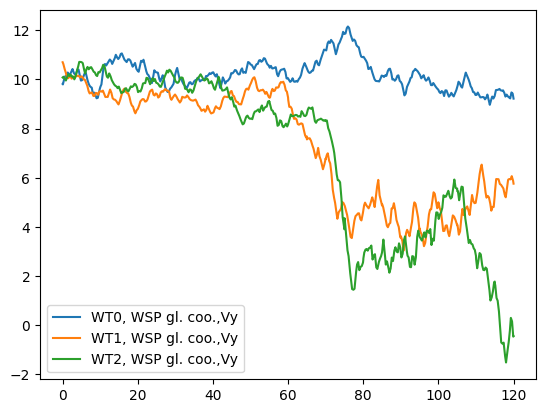

In [20]:
from wetb.gtsdf import gtsdf
plt.figure()
for i in [0,1,2]:
    f = wts.htc_lst[i].output.filename.values[0] + ".hdf5"
    time, data, info = gtsdf.load(f)
    n = 13 # output sensor number
    plt.plot(time, data[:,n], label=f"WT{i}, {info['attribute_names'][n]}")
plt.legend();

In [21]:
wts.h2.close()